/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:03:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:03:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:03:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


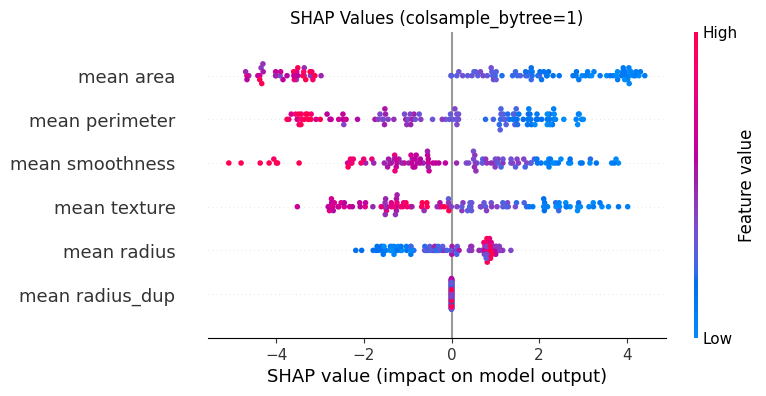

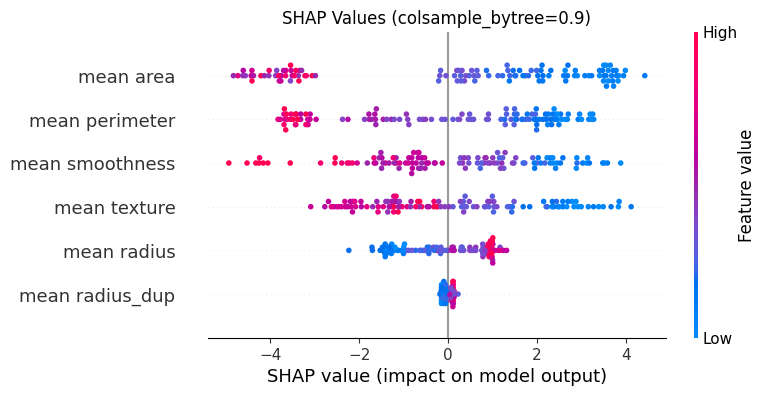

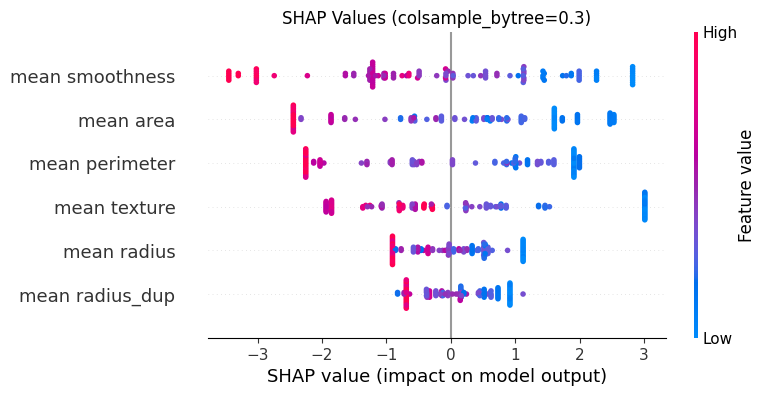

In [ ]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

# Select a fixed set of 5 features
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']

# Duplicate one of the selected features to introduce 100% correlation
duplicated_feature = 'mean radius'
df[f"{duplicated_feature}_dup"] = df[duplicated_feature]

# Define features and target
features = selected_features + [f"{duplicated_feature}_dup"]
X = df[features]
y = df["target"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train XGBoost and compute SHAP values
def train_xgb_and_compute_shap(colsample_bytree):
    model = xgb.XGBClassifier(
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
    model.fit(X_train, y_train)
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    return shap_values

# Train models with different colsample_bytree values
colsample_values = [1, 0.9, 0.3]
shap_results = {c: train_xgb_and_compute_shap(c) for c in colsample_values}

# Plot SHAP summary plots for each colsample_bytree value
for colsample in colsample_values:
    plt.figure()
    shap.summary_plot(shap_results[colsample], X_test, show=False)
    plt.title(f"SHAP Values (colsample_bytree={colsample})")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

# Select a fixed set of 5 features
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']

# Duplicate one of the selected features to introduce 100% correlation
duplicated_feature = 'mean radius'
df[f"{duplicated_feature}_dup"] = df[duplicated_feature]

# Create two versions of the dataset:
# 1. Original order (mean radius comes first)
# 2. Swapped order (mean radius_dup comes first)
X_original = df[selected_features + [f"{duplicated_feature}_dup"]]
X_swapped = df[[f"{duplicated_feature}_dup"] + selected_features]

# Target variable
y = df["target"]

# Split data
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_original, y, test_size=0.2, random_state=42)
X_train_swap, X_test_swap, _, _ = train_test_split(X_swapped, y, test_size=0.2, random_state=42)

# Function to train XGBoost and compute SHAP values
def train_xgb_and_compute_shap(X_train, X_test):
    model = xgb.XGBClassifier(
        colsample_bytree=1.0,  # Full feature sampling
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
    model.fit(X_train, y_train)
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    return shap_values

# Train models and compute SHAP values for both feature orders
shap_values_original = train_xgb_and_compute_shap(X_train_orig, X_test_orig)
shap_values_swapped = train_xgb_and_compute_shap(X_train_swap, X_test_swap)

# Convert SHAP values to DataFrame for easier comparison
shap_df_original = pd.DataFrame(shap_values_original.values, columns=X_test_orig.columns).abs().mean()
shap_df_swapped = pd.DataFrame(shap_values_swapped.values, columns=X_test_swap.columns).abs().mean()

# Combine results for easy comparison
shap_comparison = pd.DataFrame({
    "SHAP (Original Order)": shap_df_original,
    "SHAP (Swapped Order)": shap_df_swapped
})

# Print results
print(shap_comparison)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:09:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:09:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 SHAP (Original Order)  SHAP (Swapped Order)
mean area                     2.820373              2.820373
mean perimeter                1.858474              1.858474
mean radius                   0.871605              0.000000
mean radius_dup               0.000000              0.871605
mean smoothness               1.681168              1.681168
mean texture                  1.628409              1.628409
